In [82]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import re
import folium
import json
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

**Dataframe Preparation**

In [83]:
food = pd.read_pickle("food.pkl")
restaurants = pd.read_pickle("restaurants.pkl")

In [84]:
food.head()

Inspection ID             DBA Name             AKA Name  License #  \
0        2320830  THE HOXTON, CHICAGO  THE HOXTON, CHICAGO  2694640.0   
1        2320831     OGDEN PLAZA INC.     OGDEN PLAZA INC.  2475982.0   
2        2320795                  TBD         THE EXCHANGE  2698572.0   
3        2320768            The Manor            The Manor    22971.0   
4        2320719  4884 S ARCHER INC,.  4884 S ARCHER INC,.  2678088.0   

   Facility Type             Risk Zip Inspection Date Inspection Type  \
0     Restaurant  Risk 2 (Medium)  07            2019         License   
1  Grocery Store     Risk 3 (Low)  23            2019         Canvass   
2     Restaurant    Risk 1 (High)  54            2019         License   
3     Restaurant    Risk 1 (High)  32            2019         Canvass   
4  Grocery Store     Risk 3 (Low)  32            2019         License   

           Results                                         Violations  \
0             Pass  36. THERMOMETERS PROVIDED & ACCURATE - Comment...   
1  Out of Business                                                NaN   
2             Pass                                                NaN   
3         No Entry                                                NaN   
4             Fail                                                NaN   

    Latitude  Longitude  
0  41.885699 -87.648789  
1  41.855266 -87.712402  
2  41.887529 -87.632647  
3  41.807924 -87.728164  
4  41.804621 -87.719907

In [85]:
restaurants["Facility Type"].unique().tolist()

['Restaurant']

**Risk analysis:**

1) Pourcentage de 1, 2 et 3 sur chaque année

2) Différences niveaux pour même chaîne (lié à la position?)

3) Notes des chaînes/écoles

4) Distributions des notes par année

**1. Percentage distribution of risk level throughout the years** 

In [86]:
#risk distribution for every year
year_list = food["Inspection Date"].unique().tolist()
year_list.sort()
all_risks =  [[0 for _ in range(3)] for _ in range(len(year_list))]
year = 0
for i in year_list:
    all_risks[year] = food[food["Inspection Date"]==i].Risk.value_counts().sort_index().tail(3).tolist()
    year += 1

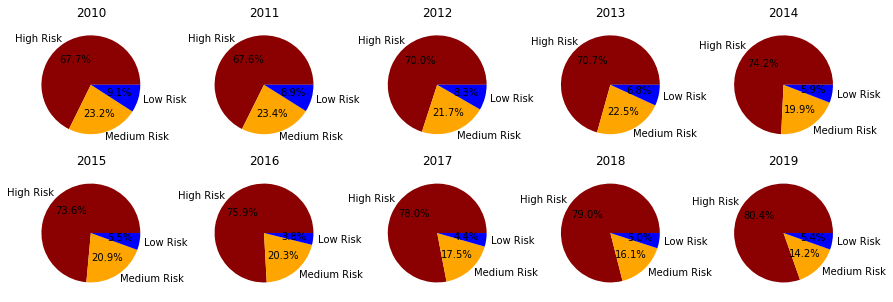

In [163]:
#plotting
labels = ['High Risk', 'Medium Risk', 'Low Risk']
fig, ax= plt.subplots(2,int(len(year_list)/2),figsize=(15,5))

year = 0
for i in range(2):
    for j in range(int(len(year_list)/2)):
        ax[i,j].pie(all_risks[year], labels = labels, autopct='%1.1f%%', colors=["darkred","orange","blue"])
        ax[i,j].set_title(year_list[year])
        year += 1

plt.show()

**Discussion**

We see that the distribution of different risk levels has slowly changed since 2010. There is a slow increase in high risk aka fast foods 

**Representation on a linear graph**

Before plotting, we need to normalize the data to be able to compare the evolution throughout the years

Text(0, 0.5, 'Percentage')

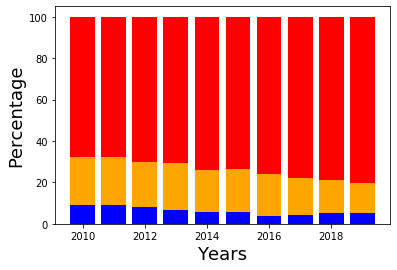

In [169]:
#x axis
years = [0]*len(year_list)
for i in range(0,len(year_list)):
    years[i]=2010+i

#y axis
scores1 = [100]*len(year_list)
scores2 = [0]*len(year_list)
scores3 = [0]*len(year_list)

#Plotting 
for j in range(0,len(year_list)):
    #scores1[j]= 100*(food[food["Inspection Date"]==year_list[j]].Risk.value_counts().sort_index().head().tolist()[0])/\
    #                (food[food["Inspection Date"]==year_list[j]].Risk.count())
    scores3[j]= 100*(food[food["Inspection Date"]==year_list[j]].Risk.value_counts().sort_index().head().tolist()[2])/\
                    (food[food["Inspection Date"]==year_list[j]].Risk.count())
    scores2[j]= 100*(food[food["Inspection Date"]==year_list[j]].Risk.value_counts().sort_index().head().tolist()[1])/\
                    (food[food["Inspection Date"]==year_list[j]].Risk.count())+scores3[j]

plt.bar(years, scores1, color='red')
plt.bar(years, scores2, color='orange')
plt.bar(years, scores3, color ='blue')

plt.xlabel("Years", fontsize=18)
plt.ylabel("Percentage", fontsize=18)

**Risk analysis per restaurant for 2018**

In [170]:
new_restaurants = restaurants[restaurants["Inspection Date"]=='2018'].copy()
new_restaurants.reset_index(drop=True, inplace=True)

In [171]:
new_restaurants.head(10)

Inspection ID             DBA Name       AKA Name  License # Facility Type  \
0        2243942        DUNKIN DONUTS  DUNKIN DONUTS  2536449.0    Restaurant   
1        2243941        DUNKIN DONUTS  DUNKIN DONUTS    23610.0    Restaurant   
2        2243922               SUBWAY         SUBWAY  1947909.0    Restaurant   
3        2243903               SUBWAY         SUBWAY  1980425.0    Restaurant   
4        2243876               SUBWAY         SUBWAY  2221641.0    Restaurant   
5        2243885           MCDONALD'S      MCDONALDS  2637057.0    Restaurant   
6        2243872               SUBWAY         SUBWAY  1904894.0    Restaurant   
7        2243828      SUBWAY SANDWICH         SUBWAY  2374636.0    Restaurant   
8        2243844  TARGET STORE # 1889      STARBUCKS  1515016.0    Restaurant   
9        2243835        Dunkin Donuts  DUNKIN DONUTS  1986419.0    Restaurant   

              Risk Zip Inspection Date        Inspection Type  \
0  Risk 2 (Medium)  54            2018                Canvass   
1  Risk 2 (Medium)  60            2018                Canvass   
2    Risk 1 (High)  29            2018                Canvass   
3    Risk 1 (High)  34            2018                Canvass   
4    Risk 1 (High)  29            2018  Canvass Re-Inspection   
5  Risk 2 (Medium)  32            2018                License   
6    Risk 1 (High)  05            2018                Canvass   
7    Risk 1 (High)  05            2018                Canvass   
8  Risk 2 (Medium)  05            2018                Canvass   
9  Risk 2 (Medium)  05            2018                Canvass   

              Results                                         Violations  \
0  Pass w/ Conditions  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...   
1                Pass  49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Com...   
2  Pass w/ Conditions  5. PROCEDURES FOR RESPONDING TO VOMITING AND D...   
3  Pass w/ Conditions  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...   
4                Pass  10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...   
5                Pass  10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...   
6     Out of Business                                                NaN   
7  Pass w/ Conditions  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...   
8                Pass  51. PLUMBING INSTALLED; PROPER BACKFLOW DEVICE...   
9  Pass w/ Conditions  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...   

    Latitude  Longitude  
0  41.896458 -87.636098  
1  41.995853 -87.670347  
2  41.775287 -87.722819  
3  41.945599 -87.766599  
4  41.778859 -87.703405  
5  41.808359 -87.696001  
6  41.865676 -87.625944  
7  41.873925 -87.630803  
8  41.867571 -87.630586  
9  41.873997 -87.630806

**Plotting on the city map**

In [172]:
#Keeping Canvass inspections and dropping duplicates (keep the highest risk level given)
new_restaurants = new_restaurants[new_restaurants["Inspection Type"]=="Canvass"]
new_restaurants.sort_values(by = "Risk", inplace=True)
new_restaurants.drop_duplicates(subset="License #", inplace=True)
new_restaurants.reset_index(drop=True, inplace=True)
new_restaurants

Inspection ID                    DBA Name       AKA Name  License #  \
0          2177026                      SUBWAY         SUBWAY  1801470.0   
1          2166318             SUBWAY SANDWICH         SUBWAY  1884292.0   
2          2166345                      SUBWAY         SUBWAY  2158242.0   
3          2166387                      SUBWAY         SUBWAY  2391330.0   
4          2166405                      SUBWAY         SUBWAY  2411733.0   
..             ...                         ...            ...        ...   
415        2214118  DUNKIN DONUTS/BASKIN ROBIN  DUNKIN DONUTS  1675002.0   
416        2214116                  McDONALD'S      MCDONALDS  1969969.0   
417        2167096      STARBUCKS COFFEE #2255      STARBUCKS    23069.0   
418        2243942               DUNKIN DONUTS  DUNKIN DONUTS  2536449.0   
419        2222949               DUNKIN DONUTS  DUNKIN DONUTS  2563522.0   

    Facility Type             Risk Zip Inspection Date Inspection Type  \
0      Restaurant    Risk 1 (High)  01            2018         Canvass   
1      Restaurant    Risk 1 (High)  66            2018         Canvass   
2      Restaurant    Risk 1 (High)  49            2018         Canvass   
3      Restaurant    Risk 1 (High)  01            2018         Canvass   
4      Restaurant    Risk 1 (High)  32            2018         Canvass   
..            ...              ...  ..             ...             ...   
415    Restaurant  Risk 2 (Medium)  30            2018         Canvass   
416    Restaurant  Risk 2 (Medium)  06            2018         Canvass   
417    Restaurant  Risk 2 (Medium)  06            2018         Canvass   
418    Restaurant  Risk 2 (Medium)  54            2018         Canvass   
419    Restaurant     Risk 3 (Low)  12            2018         Canvass   

                Results                                         Violations  \
0                  Fail  11. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, D...   
1                  Fail  16. FOOD PROTECTED DURING STORAGE, PREPARATION...   
2                  Fail  18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...   
3    Pass w/ Conditions  21. * CERTIFIED FOOD MANAGER ON SITE WHEN POTE...   
4                  Pass  32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...   
..                  ...                                                ...   
415                Pass  47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...   
416     Out of Business                                                NaN   
417                Pass  33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...   
418  Pass w/ Conditions  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...   
419     Out of Business                                                NaN   

      Latitude  Longitude  
0    41.885030 -87.626408  
1    42.008536 -87.914428  
2    41.760632 -87.586333  
3    41.884586 -87.631010  
4    41.813101 -87.723928  
..         ...        ...  
415  41.975911 -87.787723  
416  41.882700 -87.636638  
417  41.881822 -87.635437  
418  41.896458 -87.636098  
419  41.877432 -87.671768  

[420 rows x 13 columns]

In [173]:
#An idea of statistics
new_restaurants.Risk.value_counts()

Risk 1 (High)      224
Risk 2 (Medium)    195
Risk 3 (Low)         1
Name: Risk, dtype: int64

In [174]:
#Function for plotting Chicago map with markers according to risk level
#Takes a dataframe and returns the map
def map_plot (df):
    #Creating the Chicago map
    chicago_coord = [41.85, -87.7]
    riskmap = folium.Map(location=chicago_coord)

    #Low risk
    for i in range(df[df.Risk.str.contains("3")].Latitude.shape[0]):
        risk_location = [df[df.Risk.str.contains("3")].Latitude.tolist()[i], 
                          df[df.Risk.str.contains("3")].Longitude.tolist()[i]]
        folium.Marker(risk_location, popup=df[df.Risk.str.contains("3")]["AKA Name"].tolist()[i], 
                      icon=folium.Icon(color ='blue', icon = 'map-marker')).add_to(riskmap)

    #Medium risk
    for i in range(df[df.Risk.str.contains("2")].Latitude.shape[0]):
        risk_location = [df[df.Risk.str.contains("2")].Latitude.tolist()[i], 
                          df[df.Risk.str.contains("2")].Longitude.tolist()[i]]
        folium.Marker(risk_location, popup=df[df.Risk.str.contains("2")]["AKA Name"].tolist()[i], 
                      icon=folium.Icon(color ='orange', icon = 'map-marker')).add_to(riskmap)

    #High risk
    for i in range(df[df.Risk.str.contains("1")].Latitude.shape[0]):
        risk_location = [df[df.Risk.str.contains("1")].Latitude.tolist()[i], 
                          df[df.Risk.str.contains("1")].Longitude.tolist()[i]]
        folium.Marker(risk_location, popup=df[df.Risk.str.contains("1")]["AKA Name"].tolist()[i], 
                      icon=folium.Icon(color ='red', icon = 'map-marker')).add_to(riskmap)
     
    geopath = r'Boundaries - Community Areas (current).geojson'
    geodata = json.load(open(geopath))
    folium.GeoJson(geodata).add_to(riskmap)
    
    return riskmap

In [180]:
#Plotting restaurants from 2018 with colors according to risk level
m = map_plot(new_restaurants.copy())
m.save("map.html")
m

**Risk level Analysis for schools**

In [176]:
#Creation of a dataframe containing only schools from 2018 without duplicates (keep the highest risk level)
schools = food[food["Facility Type"]=='School'].copy()
schools = schools[schools["Inspection Date"]=='2018']
schools = schools[schools["Inspection Type"]=="Canvass"]
schools.sort_values(by = "Risk", inplace=True)
schools.drop_duplicates(subset="License #", inplace =True)
schools.reset_index(drop=True,inplace=True)
schools["AKA Name"] = schools["AKA Name"].str.upper()
schools.head()

Inspection ID                     DBA Name                     AKA Name  \
0        2243547    EBINGER ELEMENTARY SCHOOL   EBINGER  ELEMENTARY SCHOOL   
1        2146050  JAMES WELDON JOHNSON SCHOOL  JAMES WELDON JOHNSON SCHOOL   
2        2146030             ST. LUKE ACADEMY             ST. LUKE ACADEMY   
3        2146074     JAMES WELDON JOHNSON CPC    JAMES WELDON JOHNSON  CPC   
4        2146051                        Shoop                        SHOOP   

   License # Facility Type           Risk Zip Inspection Date Inspection Type  \
0    23051.0        School  Risk 1 (High)  31            2018         Canvass   
1    26231.0        School  Risk 1 (High)  23            2018         Canvass   
2  1878515.0        School  Risk 1 (High)  57            2018         Canvass   
3    26232.0        School  Risk 1 (High)  23            2018         Canvass   
4    25381.0        School  Risk 1 (High)  43            2018         Canvass   

  Results                                         Violations   Latitude  \
0    Pass                                                NaN  42.004436   
1    Fail  11. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, D...  41.861840   
2    Pass  38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...  41.939838   
3    Fail  2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...  41.861153   
4    Pass  32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...  41.690494   

   Longitude  
0 -87.811164  
1 -87.703176  
2 -87.666366  
3 -87.703154  
4 -87.659272

In [177]:
#preview of risk level distribution
schools.Risk.value_counts()

Risk 1 (High)      737
Risk 2 (Medium)     74
Risk 3 (Low)        20
Name: Risk, dtype: int64

The total number of schools is very large due to school being a vast term, we are going to concentrate on highschools

In [178]:
school_map = map_plot(schools[schools["AKA Name"].str.contains("HIGH")])
school_map

In [179]:
schools[schools["AKA Name"].str.contains("HIGH")].Risk.value_counts()

Risk 1 (High)      46
Risk 2 (Medium)     6
Risk 3 (Low)        2
Name: Risk, dtype: int64

In [183]:
dF=pd.read_json("https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json")

In [189]:
dF.head()

type                                           features
0  FeatureCollection  {'type': 'Feature', 'id': 'AL', 'properties': ...
1  FeatureCollection  {'type': 'Feature', 'id': 'AK', 'properties': ...
2  FeatureCollection  {'type': 'Feature', 'id': 'AZ', 'properties': ...
3  FeatureCollection  {'type': 'Feature', 'id': 'AR', 'properties': ...
4  FeatureCollection  {'type': 'Feature', 'id': 'CA', 'properties': ...

In [186]:
dF.features[0]

{'type': 'Feature',
 'id': 'AL',
 'properties': {'name': 'Alabama'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-87.359296, 35.00118],
    [-85.606675, 34.984749],
    [-85.431413, 34.124869],
    [-85.184951, 32.859696],
    [-85.069935, 32.580372],
    [-84.960397, 32.421541],
    [-85.004212, 32.322956],
    [-84.889196, 32.262709],
    [-85.058981, 32.13674],
    [-85.053504, 32.01077],
    [-85.141136, 31.840985],
    [-85.042551, 31.539753],
    [-85.113751, 31.27686],
    [-85.004212, 31.003013],
    [-85.497137, 30.997536],
    [-87.60028199999999, 30.997536],
    [-87.633143, 30.86609],
    [-87.408589, 30.674397],
    [-87.446927, 30.510088],
    [-87.37025, 30.427934],
    [-87.518128, 30.280057],
    [-87.655051, 30.247195],
    [-87.90699, 30.411504],
    [-87.934375, 30.657966],
    [-88.011052, 30.685351],
    [-88.10416, 30.499135],
    [-88.137022, 30.318396],
    [-88.394438, 30.367688],
    [-88.471115, 31.895754],
    [-88.241084, 33.796253],
    [-88.0986

In [190]:
Df = pd.read_csv("https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/US_Unemployment_Oct2012.csv")

In [191]:
Df

State  Unemployment
0     AL           7.1
1     AK           6.8
2     AZ           8.1
3     AR           7.2
4     CA          10.1
5     CO           7.7
6     CT           8.4
7     DE           7.1
8     FL           8.2
9     GA           8.8
10    HI           5.4
11    ID           6.6
12    IL           8.8
13    IN           8.4
14    IA           5.1
15    KS           5.6
16    KY           8.1
17    LA           5.9
18    ME           7.2
19    MD           6.8
20    MA           6.7
21    MI           9.1
22    MN           5.6
23    MS           9.1
24    MO           6.7
25    MT           5.8
26    NE           3.9
27    NV          10.3
28    NH           5.7
29    NJ           9.6
30    NM           6.8
31    NY           8.4
32    NC           9.4
33    ND           3.2
34    OH           6.9
35    OK           5.2
36    OR           8.5
37    PA           8.0
38    RI          10.1
39    SC           8.8
40    SD           4.4
41    TN           7.8
42    TX           6.4
43    UT           5.5
44    VT           5.0
45    VA           5.8
46    WA           7.8
47    WV           7.5
48    WI           6.8
49    WY           5.1

In [192]:
DF=pd.read_json("bound.json")

In [201]:
DF["id"]=DF.index
DF

type                                           features  id
0   FeatureCollection  {'type': 'Feature', 'properties': {'community'...   0
1   FeatureCollection  {'type': 'Feature', 'properties': {'community'...   1
2   FeatureCollection  {'type': 'Feature', 'properties': {'community'...   2
3   FeatureCollection  {'type': 'Feature', 'properties': {'community'...   3
4   FeatureCollection  {'type': 'Feature', 'properties': {'community'...   4
..                ...                                                ...  ..
72  FeatureCollection  {'type': 'Feature', 'properties': {'community'...  72
73  FeatureCollection  {'type': 'Feature', 'properties': {'community'...  73
74  FeatureCollection  {'type': 'Feature', 'properties': {'community'...  74
75  FeatureCollection  {'type': 'Feature', 'properties': {'community'...  75
76  FeatureCollection  {'type': 'Feature', 'properties': {'community'...  76

[77 rows x 3 columns]